# Unauthorized Colonies Data De-Duplication

* Import all Shapefiles **[DONE]**
* Check that there are no duplicate rows **[DONE]**
* Set Index as Column  **[DONE]**
* Identify which attribute has multiple labels (I think map or something like that) **[DONE]**
* Find the subset of Map Numbers that have multiple polygons for them **[DONE]**
* Generate PDF URLs from HTML file **[DONE]**
    * Extract URL segments via regex
    * Create URLs
    * Associate each map number to PDF URL
* Extract centroids from all PDF files **[DONE]**
    * Store centroids in a data structure associated with map number
    * This PDF centroid can be used in both algorithms below.
* Algorithm 1: Distance from PDF centroid to Polygon Centroid
    * Extract all PDF URL's from DDA website source (use combination of map no and registration number to figure out precise URL)
    * Apply PDF bounds algorithm to this
* **New Approach** Algorithm 2: Distance from PDF centroid to nearest polygon border
    * Compute distance from centroid of PDF to nearest polygon: start with `shapely.ops.nearest_points`
    * Run algorithm on random 10 selected before
        * If all 10 correct, go to comparative approach below
        * If not all 10 correct, just run algorithm 1 and have Anya manually inspect random 5% 
* Comparative Approach
    * Run both algorithms (Polygon centroid vs. nearest border)
    * If keep polygon is same for both, decide which to accept which to eliminate (return dictionary).
        * Write function to delete all duplicate rows.
    * If keep polygons are different, put in list for manual inspection.
* Generate random list of 29 (5%) of map numbers to check for. This needs to be written to a text file for Anya. 
* Complete and save

In [137]:
# Import necessary modules
import pickle
import re
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Polygon, MultiPolygon, LineString, MultiLineString 
from shapely.ops import polygonize, unary_union
from pyproj import CRS
import rasterio

import uac_utils

In [177]:
# Reload uac_utils when it gets updated
importlib.reload(uac_utils)

<module 'uac_utils' from "C:\\Users\\bwbel\\Google Drive\\slum_project\\UAC's Data Deduplication\\uac_utils.py">

In [2]:
%matplotlib inline

## Import UAC Shapefiles

In [3]:
uac_merged = gpd.read_file(filename="UAC_Merged.shp")

In [4]:
uac_merged.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Check that there are no duplicate rows

In [5]:
# No duplicate rows!
uac_utils.gdf_has_duplicate_rows(uac_merged)

False

## Set Index as a Column

In [6]:
uac_merged = uac_utils.create_index_column(uac_merged)

In [148]:
uac_merged.head(2)

,OBJECTID,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,layer,path,geometry,index
0,1,520,570,SHIV COLNY KATEWADA,D:\UC Downloads\UC_501-600-Done\520_570.pdf,1to600,/home/hb/Documents/USO/Spatial_Index_Project/U...,"POLYGON ((8568698.722 3350778.289, 8568688.910...",0
1,2,509,888,KRISHNA COLONY,D:\UC Downloads\UC_501-600-Done\509_888.pdf,1to600,/home/hb/Documents/USO/Spatial_Index_Project/U...,"POLYGON ((8580894.912 3343225.741, 8580905.114...",1


## Confirm all Geometries are (Multi)Polygons

In [8]:
uac_utils.all_polygon_geometries(uac_merged)

True

## Identify which attribute(s) has/have multiple labels

In [9]:
map_registration_dict = uac_utils.create_map_registration_dict(uac_merged)

In [150]:
# Show first 5
list(map_registration_dict.items())[:5]

[(520, {'570'}),
 (509, {'888'}),
 (516, {'658'}),
 (503, {'200'}),
 (504, {'1194'})]

Let's write some code to see if each map number has one and only one registration number

In [11]:
# Check if number of registration numbers for each Map No is always 1
for key, val in map_registration_dict.items():
    if len(val) != 1:
        print(key, val)

## Find subset of Map Numbers that are Duplicated

In [12]:
duplicate_map_numbers = uac_utils.maps_numbers_with_duplicate_polygons(uac_merged)

Number of map numbers that are duplicated: 566


## Generate PDF URLs from HTML file
* Extract URL segments via regex
* Create URLs
* Associate each map number to PDF URL

In [144]:
map_url_dict = uac_utils.generate_map_URLs(duplicate_map_numbers)

In [147]:
# Show first 5 entries
list(map_url_dict.items())[:5]

[(521, 'https://dda.org.in//tendernotices_docs/27112019/521_343.pdf'),
 (526, 'https://dda.org.in//tendernotices_docs/27112019/526_25.pdf'),
 (190, 'https://dda.org.in//tendernotices_docs/27112019/190_772%20A.pdf'),
 (184, 'https://dda.org.in//tendernotices_docs/27112019/184_809.pdf'),
 (166, 'https://dda.org.in//tendernotices_docs/27112019/166_444.pdf')]

# Extract centroids from all PDF files
* Store centroids in a data structure associated with map number
* This PDF centroid can be used in both algorithms below.

In [163]:
map_centroid_crs_dict = uac_utils.generate_map_centroid_crs(map_url_dict)

In [164]:
list(map_centroid_crs_dict.items())[:5]

[(521,
  {'centroid': <shapely.geometry.point.Point at 0x2ba6782a788>,
   'crs': CRS.from_epsg(32643)}),
 (526,
  {'centroid': <shapely.geometry.point.Point at 0x2ba672134c8>,
   'crs': CRS.from_epsg(32643)}),
 (190,
  {'centroid': <shapely.geometry.point.Point at 0x2ba6782a448>,
   'crs': CRS.from_epsg(32643)}),
 (184,
  {'centroid': <shapely.geometry.point.Point at 0x2ba6782a888>,
   'crs': CRS.from_epsg(32643)}),
 (166,
  {'centroid': <shapely.geometry.point.Point at 0x2ba6782a588>,
   'crs': CRS.from_epsg(32643)})]

In [165]:
# Write map_centroid_crs dictionary to disk:

with open('map_centroid_crs_dict.data', 'wb') as fp:
    pickle.dump(map_centroid_crs_dict, fp)

In [166]:
# Read in map_centroid_crs dictionary from disk:
with open('map_centroid_crs_dict.data', 'rb') as fp:
    map_centroid_crs_from_file = pickle.load(fp)

## TODO: Create Function to Randomly Generate 29 Maps to Check

## Algorithm 1: Distance from PDF centroid to Polygon centroid 

In [179]:
uac_utils.identify_polygon_from_map_no_and_pdf(uac_merged, 733, map_centroid_crs_dict)

{'delete': [1408, 1429, 1862, 1883], 'keep': 1861}

In [185]:
# Create new dictionary to store results of which
# polygons to keep vs. delete based on algorithm 1
polygon_map_matching1 = dict()

In [186]:
for map_number in duplicate_map_numbers:
    polygon_map_result = uac_utils.identify_polygon_from_map_no_and_pdf(uac_merged, 
                                                                        map_number, 
                                                                        map_centroid_crs_dict)
    polygon_map_matching1[map_number] = polygon_map_result 

In [187]:
list(polygon_map_matching1.items())[:5]

[(521, {'delete': [18, 672, 701, 730], 'keep': 727}),
 (526, {'delete': [26, 680, 709, 738], 'keep': 729}),
 (190,
  {'delete': [29,
    32,
    45,
    48,
    71,
    87,
    92,
    94,
    95,
    96,
    97,
    100,
    102,
    103,
    104,
    105],
   'keep': 41}),
 (184, {'delete': [33, 72], 'keep': 93}),
 (166, {'delete': [74], 'keep': 50})]

In [188]:
# Write polygon_map_matching1 dictionary to disk:

with open('polygon_map_matching1.data', 'wb') as fp:
    pickle.dump(polygon_map_matching1, fp)

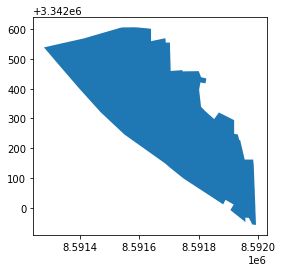

In [192]:
# To visualize map with specific index
uac_merged[uac_merged['index']==41].plot()

### Checking random 5% of duplicate maps
* 733: Correct! (https://dda.org.in/tendernotices_docs/27112019/733_291.pdf)
* 497: Correct! (https://dda.org.in/tendernotices_docs/27112019/497_676.pdf)
* 348: Correct! (https://dda.org.in/tendernotices_docs/27112019/348_1378.pdf)
* 1436: Correct! (https://dda.org.in/tendernotices_docs/27112019/1436_67.pdf)
* 1572: (https://dda.org.in/tendernotices_docs/27112019/1572_1331.pdf)
* 865: Correct! https://dda.org.in/tendernotices_docs/27112019/865_1354B.pdf
* 974: Correct! (https://dda.org.in/tendernotices_docs/27112019/974_1175_A.pdf)
* 738: Correct! (https://dda.org.in/tendernotices_docs/27112019/738_806_A.pdf)
* 990: Correct!
* 224: Correct!

## Checking that no index to be deleted is in keep list (and vice versa)

In [316]:
delete_list = []
keep_list = []

for key, val in polygon_map_matching1.items():
    delete_list.extend(val['delete'])
    keep_list.append(val['keep'])

In [319]:
[keep_num for keep_num in keep_list if keep_num in delete_list]

[]

In [320]:
[delete_num for delete_num in delete_list if delete_num in keep_list]

[]

In [351]:
# Visualize first 5 of delete_list
delete_list[:5]

[18, 672, 701, 730, 26]

## Delete rows

In [352]:
# Make copy of uac_merged
uac_merged_final = uac_merged.copy()

In [353]:
# See top of GeoDataFrame
uac_merged_final.head(2)

,OBJECTID,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,layer,path,geometry,index
0,1,520,570,SHIV COLNY KATEWADA,D:\UC Downloads\UC_501-600-Done\520_570.pdf,1to600,/home/hb/Documents/USO/Spatial_Index_Project/U...,"POLYGON ((8568698.722 3350778.289, 8568688.910...",0
1,2,509,888,KRISHNA COLONY,D:\UC Downloads\UC_501-600-Done\509_888.pdf,1to600,/home/hb/Documents/USO/Spatial_Index_Project/U...,"POLYGON ((8580894.912 3343225.741, 8580905.114...",1


In [354]:
# Created GeoDataFrame removing all rows with an index
# in delete_list
uac_merged_final = uac_merged_final.drop(index=delete_list)

In [355]:
# Check length of uac_merged_final
len(uac_merged_final)

1861

In [356]:
# Check length of uac_merged
len(uac_merged)

2991

In [357]:
# Length of delete_list + length of final list = length original list
len(delete_list) + len(uac_merged_final)

2991

## Save uac_merged_final file

In [359]:
uac_merged_final.to_file("uac_deduplicated.shp")

## Random checks for Anya

In [361]:
import random
random_ints = random.sample(range(565), 29)
random_ints

[99,
 460,
 483,
 117,
 101,
 179,
 528,
 439,
 49,
 0,
 342,
 496,
 332,
 352,
 354,
 499,
 414,
 137,
 80,
 437,
 266,
 230,
 50,
 258,
 560,
 359,
 195,
 505,
 452]